In [3]:
import pandas as pd
import os

csv_path = "dataset/train.csv"
left_train_path = "dataset/train/left/"
right_train_path = "dataset/train/right/"
df_match = pd.read_csv(csv_path)

right_img_lst = []
# list all figures in the right folder
for filename in os.listdir(right_train_path):
    if os.path.isfile(os.path.join(right_train_path, filename)):
        right_img_lst.append(filename)

# extract image path and concatenate with image file path
anchor_img_lst = [filename + ".jpg" for filename in df_match['left']]
positive_img_lst = [filename + ".jpg" for filename in df_match['right']]

# create a list of tuples of image pairs
match_pairs = list(zip(anchor_img_lst, positive_img_lst))

In [132]:
# create a list of tuples of random unmatched image pairs
unmatch_pairs = []
for i in range(len(anchor_img_lst)):
    rand_idx_lst = []
    while len(rand_idx_lst) < 19:
        rand_idx = np.random.randint(0, len(right_img_lst))
        if rand_idx not in rand_idx_lst and right_img_lst[rand_idx] != positive_img_lst[i]:
            rand_idx_lst.append(rand_idx)
            unmatch_pairs.append([anchor_img_lst[i], right_img_lst[rand_idx]])

# create triplet with one left anchor image, one right positive image, and one random negative image
triplet_pairs = []
unmatch_pairs1 = []
for i in range(len(anchor_img_lst)):
    while True:
        rand_idx = np.random.randint(0, len(right_img_lst))
        if right_img_lst[rand_idx] != match_pairs[i][1]:
            triplet = [match_pairs[i][0], match_pairs[i][1], right_img_lst[rand_idx]]
            unmatch_pairs1.append([match_pairs[i][0], right_img_lst[rand_idx]])
            triplet_pairs.append(triplet)
            break

negative_img_lst = [filename[2] for filename in triplet_pairs]

In [1]:
# prepare image for the model
def prepare_image(filepath):
    img = cv2.imread(filepath)
    img = cv2.resize(img, (64,64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = img.astype("float32")
    img /= 255.0
    return img

In [9]:
# create a list of anchor, positive, and negative images
anchor_imgs = [prepare_image(os.path.join(left_train_path, filename)) for filename in anchor_img_lst]
positive_imgs = [prepare_image(os.path.join(right_train_path, filename)) for filename in positive_img_lst]
negative_imgs = [prepare_image(os.path.join(right_train_path, filename)) for filename in negative_img_lst]

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

2023-09-17 16:04:14.791056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
input_shape = (245, 200, 3)
# Define the CNN model
base_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Define the anchos, positive, and negative inputs
input_anchor = tf.keras.Input(shape=input_shape)
input_positive = tf.keras.Input(shape=input_shape)
input_negative = tf.keras.Input(shape=input_shape)

# Encode both left and right images using the same base network
encoded_anchor = base_model(input_anchor)
encoded_positive = base_model(input_positive)
encoded_negative = base_model(input_negative)

# Calculate the Euclidean distance between the embeddings
# Can be changed to other distance functions (similarity functions) such as cosine similarity, L1 distance, etc.
distance_positive = tf.norm(encoded_anchor - encoded_positive, axis=-1)
distance_negative = tf.norm(encoded_anchor - encoded_negative, axis=-1)

# Calculate the triplet loss as described by the FaceNet paper
margin = 0.2  
triplet_loss = tf.keras.layers.Lambda(lambda x: tf.maximum(x[0] - x[1] + margin, 0.0),
                                      output_shape=lambda x: x[0])([distance_positive, distance_negative])

# Define the Siamese model
siamese_model = tf.keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=triplet_loss)

# # Define the triplet loss function
# def triplet_loss(margin=margin):
#     def loss(y_true, y_pred):
#         anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
#         pos_distance = tf.norm(anchor - positive, axis=-1)
#         neg_distance = tf.norm(anchor - negative, axis=-1)
#         return tf.maximum(pos_distance - neg_distance + margin, 0.0)
#     return loss

# Compile the model with the triplet loss
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
siamese_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 245, 200, 3)]        0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 245, 200, 3)]        0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None, 245, 200, 3)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 1)                    9635756   ['input_17[0][0]',            
                                                          9          'input_18[0][0]',      

In [ ]:
# Prepare your triplets and train the model
labels= np.zeros((len(anchor_imgs),))
siamese_model.fit([np.array(anchor_imgs), np.array(positive_imgs), np.array(negative_imgs)], labels, epochs=20, batch_size=16)

## Baseline Model

做一个二分类的model，input是（anchor，right），用crossentropy loss，label就是match和unmatched

In [6]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.keras.backend.sum(tf.keras.backend.square(x - y), axis=1, keepdims=True)
    return tf.keras.backend.sqrt(tf.keras.backend.maximum(sum_square, tf.keras.backend.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.
    sqaure_pred = tf.keras.backend.square(y_pred)
    margin_square = tf.keras.backend.square(tf.keras.backend.maximum(margin - y_pred, 0))
    return tf.keras.backend.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [121]:
input_shape = (64,64,3)
# use ResNet50 as the base model
# base_model = tf.keras.applications.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=input_shape,
#         pooling='avg',
#     )

base_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dense(1, activation='sigmoid')  # Binary classification
])


input_left = tf.keras.layers.Input(shape=input_shape)
input_right = tf.keras.layers.Input(shape=input_shape)

output_left = base_model(input_left)
output_right = base_model(input_right)

l1_distance = tf.keras.layers.Lambda(lambda tensors: tf.keras.backend.abs(tensors[0] - tensors[1]))([output_left, output_right])

#distance = tf.keras.layers.Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([output_left, output_right])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(l1_distance)

# Define MLP head
mlp_units = 128
mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(mlp_units, activation='relu'),
])

transformed_output_left = mlp(output_left)
transformed_output_right = mlp(output_right)

# Concatenate the encoder and MLP outputs
concatenated = tf.keras.layers.Concatenate()([transformed_output_left, transformed_output_right])

# Define the classification head
classification_output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)

# Define the Siamese model
siamese_model = tf.keras.Model(inputs=[input_left, input_right], outputs=classification_output)
#siamese_model = tf.keras.Model(inputs=[input_left, input_right], outputs=outputs)

siamese_model.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_38 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential_19 (Sequential)  (None, 128)                  7392320   ['input_37[0][0]',            
                                                                     'input_38[0][0]']            
                                                                                                  
 sequential_20 (Sequential)  (None, 128)                  16512     ['sequential_19[0][0]',

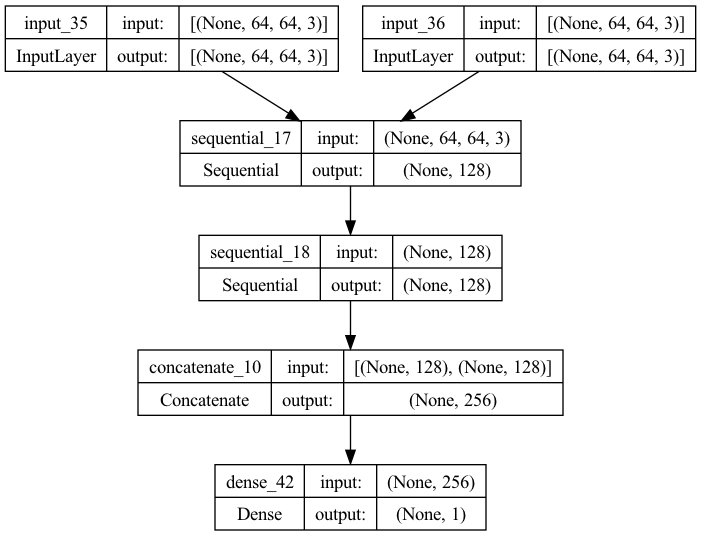

In [119]:
tf.keras.utils.plot_model(siamese_model,show_shapes=True)

In [135]:
match_labels = [[1] for i in range(len(anchor_img_lst))]
unmatch_labels = [[0] for i in range(len(unmatch_pairs))]
labels = np.array(match_labels + unmatch_labels)
pairs = [[prepare_image(os.path.join(left_train_path, pair[0])), prepare_image(os.path.join(right_train_path, pair[1]))] for pair in match_pairs+unmatch_pairs]
pairs = np.array(pairs)

/var/folders/1l/kxzgd7qj0958pcn5xj1149ph0000gn/T/ipykernel_67225/4014957305.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


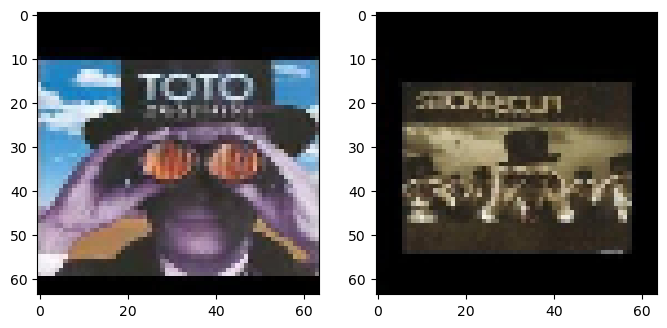

In [100]:
plt.subplots(figsize=(8, 8))
plt.subplot(1,2,1)
plt.imshow(pairs[0][0])
plt.subplot(1,2,2)
plt.imshow(pairs[0][1])
plt.show()

In [122]:
# Compile the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Prepare your triplets and train the model
siamese_model.fit([pairs[:, 0], pairs[:, 1]], labels[:], epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
50/50 [==============================] - 64s 1s/step - loss: 0.6952 - binary_accuracy: 0.6119 - val_loss: 0.9139 - val_binary_accuracy: 0.0000e+00
Epoch 2/20
50/50 [==============================] - 56s 1s/step - loss: 0.6636 - binary_accuracy: 0.6250 - val_loss: 1.0659 - val_binary_accuracy: 0.0000e+00
Epoch 3/20
50/50 [==============================] - 57s 1s/step - loss: 0.6642 - binary_accuracy: 0.6256 - val_loss: 0.9540 - val_binary_accuracy: 0.0000e+00
Epoch 4/20
50/50 [==============================] - 55s 1s/step - loss: 0.6605 - binary_accuracy: 0.6263 - val_loss: 0.9911 - val_binary_accuracy: 0.0012
Epoch 5/20
50/50 [==============================] - 57s 1s/step - loss: 0.6573 - binary_accuracy: 0.6237 - val_loss: 0.9494 - val_binary_accuracy: 0.0213
Epoch 6/20
50/50 [==============================] - 72s 1s/step - loss: 0.6448 - binary_accuracy: 0.6356 - val_loss: 1.0945 - val_binary_accuracy: 0.0200
Epoch 7/20
50/50 [==============================] - 70s 1s/step 

In [84]:
left_test_path = "dataset/test/left/"
right_test_path = "dataset/test/right/"

left_test_lst = []
right_test_lst = []
# list all figures in the right folder
for filename in os.listdir(right_test_path):
    if os.path.isfile(os.path.join(right_test_path, filename)):
        right_test_lst.append(filename)
for filename in os.listdir(left_test_path):
    if os.path.isfile(os.path.join(left_test_path, filename)):
        left_test_lst.append(filename)

left_test_imgs = [prepare_image(os.path.join(left_test_path, left_test_lst[i])) for i in range(len(left_test_lst))]
right_test_imgs = [prepare_image(os.path.join(right_test_path, right_test_lst[i])) for i in range(len(right_test_lst))]

In [129]:
imageA = anchor_imgs[0]
imageB = positive_imgs[383]
# create a copy of both the images for visualization purpose
origA = imageA.copy()
origB = imageB.copy()
# add channel a dimension to both the images
imageA = np.expand_dims(imageA, axis=-1)
imageB = np.expand_dims(imageB, axis=-1)
# add a batch dimension to both images
imageA = np.expand_dims(imageA, axis=0)
imageB = np.expand_dims(imageB, axis=0)
# scale the pixel values to the range of [0, 1]
imageA = imageA / 255.0
imageB = imageB / 255.0
# use our siamese model to make predictions on the image pair,
# indicating whether or not the images belong to the same class
preds = siamese_model.predict([imageA, imageB])
proba = preds[0][0]

1/1 [==============================] - 0s 78ms/step


In [130]:
proba

0.7277937

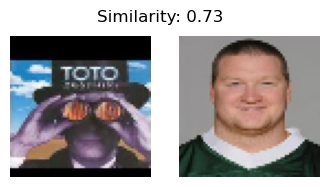

In [131]:
# initialize the figure
fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
plt.suptitle("Similarity: {:.2f}".format(proba))
# show first image
ax = fig.add_subplot(1, 2, 1)
plt.imshow(origA)
plt.axis("off")
# show the second image
ax = fig.add_subplot(1, 2, 2)
plt.imshow(origB)
plt.axis("off")
# show the plot
plt.show()